# Project Discrete Optimization and Decision Making

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import random
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

## Module 1

This project involves designing an efficient last-mile delivery system for a city. A company has a set of customers $C = \{1, \ldots, \overline{c}\}$, each requiring the delivery of a package. The weight of each package $w_c, c \in C$ is known. The delivery time for each customer is equal to $s_c, c \in C$. The company has a set $K = \{1, \ldots, \overline{k}\}$ of delivery vans available that all start from the same depot $0$ at time $0$, have the same capacity $W$, and must return to the depot withing $t_{max}$. Each vehicle can exit the depot at most once. The problem can be formulated on a complete directed graph $G = (V, A)$ where $V = C \cup \{0\}$ is the set of nodes and $A = \{(i,j) | i, j \in V, i \neq j\}$ is the set of arcs. Each arc can be traveled at most once by any of the vehicles. For each arc $(i, j) \in A$, let us define the time $t_{ij}$ required to travel over the arc. Travel times satisfy the triangle inequality. The goal of the company is to minimize the total time required to complete the service for all customers. Provide a mathematical formulation of the problem and its optimal solution. 

In [11]:
# Sample data
N_0 = [1, 2, 3]  # Customers
K = [1,2]     # Vehicles
N = N_0 + [0]    # Nodes (including depot 0)
A = [(i, j) for i in N for j in N if i != j] #set of arcs
Q = 10         # Vehicle capacity
q = {1: 2, 2: 3, 3: 4}  # Package weights
t = {0: 0, 1: 40, 2: 20, 3: 10}  # Service times for each customer
# Travel times
t_ij = {
    (0, 1): 20, (0, 2): 20, (0, 3): 20,
    (1, 0): 20, (1, 2): 25, (1, 3): 30,
    (2, 0): 40, (2, 1): 25, (2, 3): 35,
    (3, 0): 30, (3, 1): 30, (3, 2): 35
}

In this module we add the following variables:
- $x_{ij} = 
\begin{cases} 
1 & \text{if a vehicle traverses arc (i, j)} \\
0 & \text{otherwise}
\end{cases}
$
- $f_{ij} = $ amount of commodity flowing on arc $(i, j)$
- $y[i] = $ starting time of service at node i
- $s[i] = $ route duration if i is the last node visited before the depot

and the following constraints:
- Number of exit vehicles $==$ Total number of vehicles
    $$ \sum_{j \in N_0} x_{0j} = K$$
- Vehicle entering each node $== 1$
    $$ \sum_{j \in N_0} x_{ij} = 1\ \forall i \in N_0 $$
- Vehicle exiting each node $== 1$
    $$ \sum_{j \in N_0} x_{ij} = 1\ \forall j \in N_0 $$
- Control that each package is served correctly to each node
    $$ \sum_{j \in N} f_{ji} - \sum_{j \in N} f_{ij} \ \forall i \in N_0$$
- Current capacity $>$ next necessary capacity
    $$ q_jX_{ij} \leq f_{ij} \leq (Q - q_i)x_{ij} \ \forall (i, j) \in A $$
- $$ y_i - y_j + t_i + t_{ij} \leq M(1 - x_{ij})\  \forall (i, j) \in A $$
- $$ y_j + t_j - s_j \leq L(1 - x_{j0})\ \forall j \in N_0 $$

In [12]:
model = gp.Model("module_1")
x = model.addVars(A, vtype=GRB.BINARY, name="x") #1 if a vehicle traverses (i, j), 0 otherwise
f = model.addVars(A, vtype=GRB.INTEGER, name = "f") #amount of commodity flowing on arc (i,j) 
y = model.addVars(N_0, vtype=GRB.INTEGER, name = "y") #starting time of service at node j
s = model.addVars(N_0, vtype = GRB.INTEGER, name="s") #route duration if j is the last node visited before the depot

model.setObjective(gp.quicksum((t_ij[i, j]) * x[i, j] for (i, j) in A), GRB.MINIMIZE)


# (5) number of exit vehicles == total number of vehicles
constraint_vehicles = None
for j in N_0:
    if constraint_vehicles == None:
        constraint_vehicles = x[0, j]
    else:
        constraint_vehicles += x[0, j]
model.addConstr(constraint_vehicles == len(K))

# (6) Vehicles entering in each node == 1
for i in N_0:
    constraint_entering_flow = None
    for j in N:
        if i != j:
            if constraint_entering_flow == None:
                constraint_entering_flow = x[i, j]
            else:
                constraint_entering_flow += x[i, j]
    model.addConstr(constraint_entering_flow == 1)
# (7) Vehicles out of each node == 1
for j in N_0:
    constraint_exit_flow = None
    for i in N:
        if i != j:
            if constraint_exit_flow == None:
                constraint_exit_flow = x[i, j]
            else:
                constraint_exit_flow += x[i, j]
    model.addConstr(constraint_exit_flow == 1)

# (8) Control that each package is served correctly to each node
for i in N_0:
    constraint_quantity_stability = None
    sum_fji = None
    sum_fij = None
    for j in N:
        if i != j:
            if sum_fji == None:
                sum_fji = f[j, i]
            else:
                sum_fji += f[j, i]
            if sum_fij == None:
                sum_fij = f[i, j]
            else:
                sum_fij += f[i, j]
    model.addConstr((sum_fji - sum_fij) == q[i])

# (9) current capacity > next necessary capacity
for (i,j) in A:
    if j != 0:
        model.addConstr((q[j] * x[i, j]) <= f[i, j])
    if i != 0:
        model.addConstr(f[i, j] <= (Q - q[i])*x[i, j])

# (11) ???????????
M = 10e7
for (i, j) in A:
    if i != 0 and j != 0:
        model.addConstr(y[i] - y[j] + t[i] + t_ij[i, j] <= M*(1 - x[i, j]))
    elif j != 0:
        model.addConstr(-y[j] + t[i] + t_ij[i, j] <= M*(1 - x[i, j]))

L = 10e7
for j in N_0:
    model.addConstr(y[j] + t[j] - s[j]  <= L*(1 - x[j, 0]))

In [13]:
model.optimize()

# Display results
if model.Status == GRB.OPTIMAL:
    solutions = model.getAttr('x', x)
    for key in solutions:
        if solutions[key] > 0.5:
            print(key, "->",solutions[key])
    model.write('model.lp')
    for v in model.getVars():
        if 'y' in  v.VarName :
            print(f"{v.VarName} = {v.X}")
        if 's' in v.VarName:
            print(f"{v.VarName} = {v.X}")
if model.Status == GRB.INFEASIBLE:
        model.computeIIS()
        model.write('model.ilp')

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 23.3.0 23D60)

CPU model: Intel(R) Core(TM) i3-1000NG4 CPU @ 1.10GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 40 rows, 30 columns and 108 nonzeros
Model fingerprint: 0x08240717
Variable types: 0 continuous, 30 integer (12 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]
Found heuristic solution: objective 130.0000000
Presolve removed 32 rows and 24 columns
Presolve time: 0.00s
Presolved: 8 rows, 6 columns, 20 nonzeros
Variable types: 0 continuous, 6 integer (3 binary)
Found heuristic solution: objective 115.0000000

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 4 (of 4 available processors)

Solution count 2: 115 130 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.150000000000e+02, be

## Module 2

In the second module we add the following constraints:
- Time window constraint:
    $$ a_i \leq y_i \leq b_i $$
- A tuple $(i, j, l)$ indicates that if node $i$ and node $j$ are visited by the same van, then node $j$ cannot be served by the same van:

    for direct linkages: $ x_{ij} + x_{il} + x_{jl} \leq 1$

    for undirect linkages with one intermediate node: $ x_{ij} + x_{ik} + x_{jk} + x_{kl} \leq 2 $

In [2]:
# Sample data
N_0 = [1, 2, 3]  # Customers
K = [1,2]     # Vehicles
N = N_0 + [0]    # Nodes (including depot 0)
A = [(i, j) for i in N for j in N if i != j] #set of arcs
Q = 10         # Vehicle capacity
q = {1: 2, 2: 3, 3: 4}  # Package weights
t = {0: 0, 1: 40, 2: 20, 3: 10}  # Service times for each customer
# Travel times
t_ij = {
    (0, 1): 20, (0, 2): 20, (0, 3): 20,
    (1, 0): 20, (1, 2): 25, (1, 3): 30,
    (2, 0): 40, (2, 1): 25, (2, 3): 35,
    (3, 0): 30, (3, 1): 30, (3, 2): 35
}
a = {1: 5, 2: 15, 3: 25}  # lower time window constraint
b = {1: 100, 2: 100, 3: 100} # upper time window constraint
R = [(1,3,2)] # if client 1 and 2 are served by the same van then client 3's van must be different

In [25]:
model = gp.Model("module_2")
x = model.addVars(A, vtype=GRB.BINARY, name="x") #1 if a vehicle traverses (i, j), 0 otherwise
f = model.addVars(A, vtype=GRB.INTEGER, name = "f") #amount of commodity flowing on arc (i,j) 
y = model.addVars(N_0, vtype=GRB.INTEGER, name = "y") #starting time of service at node j
s = model.addVars(N_0, vtype = GRB.INTEGER, name="s") #route duration if j is the last node visited before the depot
z = model.addVars(N_0, K, vtype=GRB.BINARY, name="z") #1 if node i is served by van k

model.setObjective(gp.quicksum((t_ij[i, j]) * x[i, j] for (i, j) in A), GRB.MINIMIZE)


# (5) number of exit vehicles == total number of vehicles
constraint_vehicles = None
for j in N_0:
    if constraint_vehicles == None:
        constraint_vehicles = x[0, j]
    else:
        constraint_vehicles += x[0, j]
model.addConstr(constraint_vehicles == len(K))

# (6) Vehicles entering in each node == 1
for i in N_0:
    constraint_entering_flow = None
    for j in N:
        if i != j:
            if constraint_entering_flow == None:
                constraint_entering_flow = x[i, j]
            else:
                constraint_entering_flow += x[i, j]
    model.addConstr(constraint_entering_flow == 1)
# (7) Vehicles out of each node == 1
for j in N_0:
    constraint_exit_flow = None
    for i in N:
        if i != j:
            if constraint_exit_flow == None:
                constraint_exit_flow = x[i, j]
            else:
                constraint_exit_flow += x[i, j]
    model.addConstr(constraint_exit_flow == 1)

# (8) Control that each package is served correctly to each node
for i in N_0:
    constraint_quantity_stability = None
    sum_fji = None
    sum_fij = None
    for j in N:
        if i != j:
            if sum_fji == None:
                sum_fji = f[j, i]
            else:
                sum_fji += f[j, i]
            if sum_fij == None:
                sum_fij = f[i, j]
            else:
                sum_fij += f[i, j]
    model.addConstr((sum_fji - sum_fij) == q[i])

# (9) current capacity > next necessary capacity
for (i,j) in A:
    if j != 0:
        model.addConstr((q[j] * x[i, j]) <= f[i, j])
    if i != 0:
        model.addConstr(f[i, j] <= (Q - q[i])*x[i, j])

# (11) ???????????
M = 10e7
for (i, j) in A:
    if i != 0 and j != 0:
        model.addConstr(y[i] - y[j] + t[i] + t_ij[i, j] <= M*(1 - x[i, j]))
    elif j != 0:
        model.addConstr(-y[j] + t[i] + t_ij[i, j] <= M*(1 - x[i, j]))

L = 10e7
for j in N_0:
    model.addConstr(y[j] + t[j] - s[j]  <= L*(1 - x[j, 0]))

# (10) time window constraint
for i in N_0:
    model.addConstr(y[i] >= a[i], name=f"time_window_lower_{i}")
    model.addConstr(y[i] <= b[i], name=f"time_window_upper_{i}")

# tuple constraint with variable z (doesn't work)
"""for i in N_0:
    model.addConstr(gp.quicksum(z[i, k] for k in K) == 1)

for i in N_0:
    for j in N_0:
        if i != j:
            for k in K:
                model.addConstr(z[i, k] - z[j, k]  <=M*(1 - x[i, j]) )
        
for (i, j, l) in R:
    for k in K:
        model.addConstr(z[i, k] + z[j, k] + z[l, k] <= 2)"""


#tuple constraint without variable z
# direct linkage between i,j,l
for (i, j, l) in R:
    model.addConstr(x[i, j] + x[i, l] + x[j, l] <= 1)

# undirect linkage between i,j,l (example: i ==> j ==> k ==> l) consider only one intermediate node
for (i, j, l) in R:
    for k in N_0:
        if k != i and k != j and k != l:
            model.addConstr(x[i, j] + x[j, k] + x[i, k] + x[k, l] <= 2)
c = 'ciao'

In [26]:
model.optimize()

# Display results
if model.Status == GRB.OPTIMAL:
    solutions = model.getAttr('x', x)
    for key in solutions:
        if solutions[key] > 0.5:
            print(key, "->",solutions[key])
    model.write('model.lp')
    for v in model.getVars():
        if 'y' in  v.VarName :
            print(f"{v.VarName} = {v.X}")
        if 's' in v.VarName:
            print(f"{v.VarName} = {v.X}")
if model.Status == GRB.INFEASIBLE:
        model.computeIIS()
        model.write('model.ilp')

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 63 rows, 36 columns and 162 nonzeros
Model fingerprint: 0xc55bfcd9
Variable types: 0 continuous, 36 integer (18 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]
Found heuristic solution: objective 115.0000000
Presolve removed 63 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 115 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.150000000000e+02, best bound 1.150000000000e+02, gap 0.0000%
(1, 0) -> 1.0
(2, 1) -> 1.0
(3, 0) -> 1.0
(0, 2) -> 1.0
(0, 3) -> 1.0
y[1] = 100.0
y[2] = 20.0
y[3]

## Module 3

The company has introduced a set $P = {1, ...,p}$ of parcel lockers across the city that can be visited instead of going directly to the customers house.

So we have a new graph $G' = (V', A')$ where $V' = V \cup P$. Let us define $d_{ij}$ the distance between lockers and customers. A customer can be served if the distance from the locker is lower than $d$. 

In [27]:
import random

In [87]:
# Sample data
N_0 = [1, 2, 3]  # Customers
K = [1,2]     # Vehicles
l = [4, 5, 6]  # Lockers
N = N_0 + [0] + l    # Nodes (including depot 0)
A = [(i, j) for i in N for j in N if i != j] #set of arcs
Q = 10         # Vehicle capacity
q = {1: 2, 2: 3, 3: 4, 4:4, 5:5, 6:6}  # Package weights
t = {0: 0, 1: 40, 2: 20, 3: 10}  # Service times for each customer
# Travel times
t_ij = {}
for (i, j) in A:
    if j in l:
        t_ij[(i, j)] = 1
    else:
        t_ij[(i, j)] = 100
d_ij = t_ij # Linear relationship with time
d_j = 10  # Maximum distance threshold for a customer to be served by a locker


In [96]:
model = gp.Model("module_3")
x = model.addVars(A, vtype=GRB.BINARY, name="x") #1 if a vehicle traverses (i, j), 0 otherwise
f = model.addVars(A, vtype=GRB.INTEGER, name = "f") #amount of commodity flowing on arc (i,j) 
y = model.addVars(N_0, vtype=GRB.INTEGER, name = "y") #starting time of service at node j
s = model.addVars(N_0, vtype = GRB.INTEGER, name="s") #route duration if j is the last node visited before the depot
z = model.addVars(N_0, l, vtype= GRB.BINARY, name = "z") # 1 if customer goes to locker l 0 otherwise
model.setObjective(gp.quicksum((t_ij[i, j]) * x[i, j] for (i, j) in A), GRB.MINIMIZE)


# (5) number of exit vehicles == total number of vehicles
constraint_vehicles = None
for j in (N_0+l):
    if constraint_vehicles == None:
        constraint_vehicles = x[0, j]
    else:
        constraint_vehicles += x[0, j]
model.addConstr(constraint_vehicles == len(K))

# (6) Vehicles entering in each node == 1
for i in (N_0+l):
    constraint_entering_flow = None
    for j in N:
        if i != j:
            if constraint_entering_flow == None:
                constraint_entering_flow = x[i, j]
            else:
                constraint_entering_flow += x[i, j]
    model.addConstr(constraint_entering_flow == 1)
# (7) Vehicles out of each node == 1
for j in (N_0+l):
    constraint_exit_flow = None
    for i in N:
        if i != j:
            if constraint_exit_flow == None:
                constraint_exit_flow = x[i, j]
            else:
                constraint_exit_flow += x[i, j]
    model.addConstr(constraint_exit_flow == 1)

# (8) Control that each package is served correctly to each node
for i in (N_0+l):
    constraint_quantity_stability = None
    sum_fji = None
    sum_fij = None
    for j in N:
        if i != j:
            if sum_fji == None:
                sum_fji = f[j, i]
            else:
                sum_fji += f[j, i]
            if sum_fij == None:
                sum_fij = f[i, j]
            else:
                sum_fij += f[i, j]
    model.addConstr((sum_fji - sum_fij) == q[i])

# (9) current capacity > next necessary capacity
for (i,j) in A:
    if j != 0 and j in N_0:
        model.addConstr((q[j] * x[i, j]) <= f[i, j])
    if i != 0 and i in N_0:
        model.addConstr(f[i, j] <= (Q - q[i])*x[i, j])

# (11) ???????????
M = 10e7
for (i, j) in A:
    if i in N_0 and j in N_0:
        if i != 0 and j != 0 : 
            model.addConstr(y[i] - y[j] + t[i] + t_ij[i, j] <= M*(1 - x[i, j]))
        elif j != 0:
            model.addConstr(-y[j] + t[i] + t_ij[i, j] <= M*(1 - x[i, j]))

L = 10e7
for j in N_0:
    model.addConstr(y[j] + t[j] - s[j]  <= L*(1 - x[j, 0]))

# Customer can go only in one locker.
# Customer can be served through a locker if the distance from the locker is lower than d.
# (12) Locker service constraints
lockers_available = l.copy()
for v in N_0:
    for p in lockers_available:
        if d_ij[v, p] <= d_j:
            model.addConstr(z[v, p] == 1)
            lockers_available.remove(p)
            break
        
for i in N_0:
    sum_lockers = None
    for p in l:
        if sum_lockers == None:
            sum_lockers = z[i, p]
        else:
            sum_lockers += z[i, p]
    sum_other = None
    for j in (N_0):
        if i != j:
            if sum_other == None:
                sum_other = x[i, j]
            else:
                sum_other += x[i, j]
    model.addConstr(sum_lockers + sum_other == 1)

for i in N_0:
    sum_z = None
    for p in l:
        if sum_z == None:
            sum_z = z[i, p]
        else:
            sum_z += z[i, p]
    model.addConstr(sum_z <= 1)


In [97]:
model.optimize()

# Display results
if model.Status == GRB.OPTIMAL:
    solutions = model.getAttr('x', x)
    for key in solutions:
        if solutions[key] > 0.5:
            print(key, "->",solutions[key])
    model.write('model.lp')
    for v in model.getVars():
        if 'y' in  v.VarName :
            print(f"{v.VarName} = {v.X}")
        if 's' in v.VarName:
            print(f"{v.VarName} = {v.X}")
        if 'z' in v.VarName:
            print(f"{v.VarName} = {v.X}")
if model.Status == GRB.INFEASIBLE:
        model.computeIIS()
        model.write('model.ilp')

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 70 rows, 99 columns and 261 nonzeros
Model fingerprint: 0xbd53e0f5
Variable types: 0 continuous, 99 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+08]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+08]
Found heuristic solution: objective 503.0000000
Presolve removed 36 rows and 51 columns
Presolve time: 0.00s
Presolved: 34 rows, 48 columns, 153 nonzeros
Variable types: 0 continuous, 48 integer (39 binary)

Root relaxation: cutoff, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0       503.00000  503.00000  0.00%     -    0s

Explored 

## Module 2 (New Version)

### Input:

In [33]:
# Nodes
n = 11
clients = [i for i in range(n) if i != 0]
nodes = [0] + clients
arcs = [(i,j) for i in nodes for j in nodes if i != j]

# Packages Request
np.random.seed(0) # se lo cambio cambia la disposizione dei customer sul piano
q = {n:np.random.randint(10,15) for n in clients}
q[0] = 0

# Time Window
e = {0:0, 1:10, 2:10, 3:10, 4:20, 5:20, 6:20, 7:40, 8:40, 9:40, 10:40} # minimum time
l = {0:200, 1:100, 2:100, 3:100, 4:150, 5:150, 6:150, 7:180, 8:180, 9:180, 10:180} # maximum time

s = {n:np.random.randint(3,5) for n in clients} # service time in node i
s[0] = 0

# Vehicles
vehicles = [1,2,3,4]
Q = {1:50, 2:50, 3:25, 4:25}

# Coordinates
X = np.random.rand(len(nodes)) * 100
Y = np.random.rand(len(nodes)) * 100

# Distances and times
distances = {(i,j): np.hypot(X[i] - X[j], Y[i] - Y[j]) for i in nodes for j in nodes if i != j}
time = {(i,j): np.hypot(X[i] - X[j], Y[i] - Y[j]) for i in nodes for j in nodes if i != j}

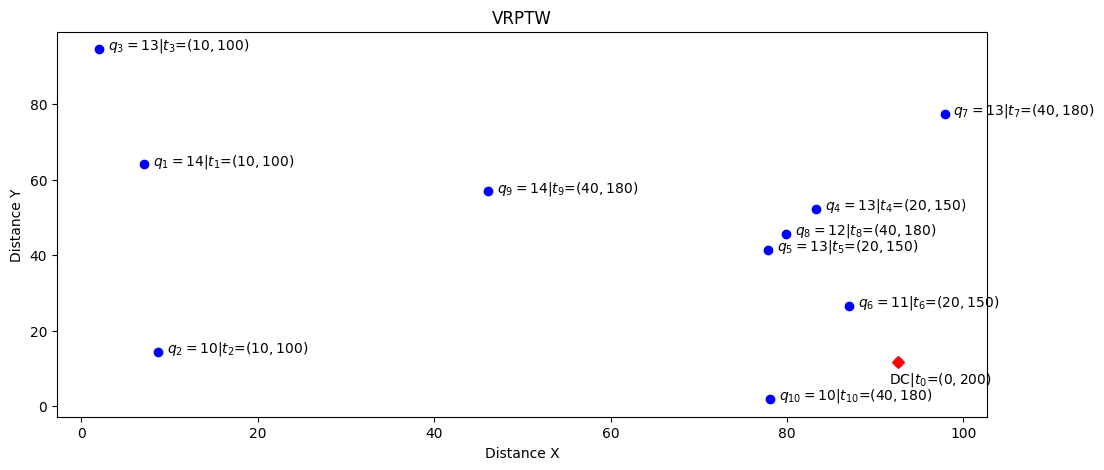

In [34]:
# Scatter Plot
plt.figure(figsize=(12, 5))
plt.scatter(X, Y, color = 'blue')

plt.scatter(X[0], Y[0], color = 'red', marker = 'D')
plt.annotate("DC|$t_{%d}$=(%d$,%d$)" %(0,e[0],l[0]),(X[0]-1,Y[0]-5.5))

for i in clients:
    plt.annotate('$q_{%d}=%d$|$t_{%d}$=(%d$,%d$)' %(i,q[i],i,e[i],l[i]),(X[i]+1,Y[i]))

plt.xlabel('Distance X')
plt.ylabel('Distance Y')
plt.title('VRPTW')

plt.show()

### Solution:

In [35]:
# Model Arcs
arc_var = [(i, j, k) for i in nodes for j in nodes for k in vehicles if i != j]
arc_time = [(i, k) for i in nodes for k in vehicles]

In [36]:
# Model
model = gp.Model('VRPTW')

# Variables
x = model.addVars(arc_var, vtype=GRB.BINARY, name='x')
t = model.addVars(arc_time, vtype=GRB.CONTINUOUS, name='t')

# Objective Function 
model.setObjective(gp.quicksum(distances[i,j]*x[i,j,k] for i,j,k in arc_var), GRB.MINIMIZE)

# Constraints
# Departure and arrival from the depot
model.addConstrs(gp.quicksum(x[0,j,k] for j in clients) <= 1 for k in vehicles)
model.addConstrs(gp.quicksum(x[i,0,k] for i in clients) <= 1 for k in vehicles)

# One vehicle per nodo
model.addConstrs(gp.quicksum(x[i,j,k] for j in nodes for k in vehicles if i!=j) == 1 for i in clients)

# Flow Conservation
model.addConstrs(gp.quicksum(x[i,j,k] for j in nodes if i!=j) - gp.quicksum(x[j,i,k] for j in nodes if i!=j)==0
                 for i in nodes for k in vehicles)

# Capacity of each vehicle
model.addConstrs(gp.quicksum(q[i]*gp.quicksum(x[i,j,k] for j in nodes if i!=j)for i in clients) <= Q[k]
                 for k in vehicles)

# Time Window
model.addConstrs((x[i,j,k]==1)>> (t[i,k]+s[i]+time[i,j] == t[j,k]) for i in clients for j in clients
                 for k in vehicles if i!=j)

model.addConstrs(t[i,k] >= e[i] for i,k in arc_time)
model.addConstrs(t[i,k] <= l[i] for i,k in arc_time)


model.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 23.3.0 23D60)

CPU model: Intel(R) Core(TM) i3-1000NG4 CPU @ 1.10GHz


Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 154 rows, 484 columns and 1848 nonzeros
Model fingerprint: 0x2750d1db
Model has 360 general constraints
Variable types: 44 continuous, 440 integer (440 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
  GenCon rhs range [8e+00, 1e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 444 rows and 0 columns
Presolve removed 0 rows and 50 columns
Presolve time: 0.21s
Presolved: 598 rows, 434 columns, 4142 nonzeros
Variable types: 116 continuous, 318 integer (318 binary)
Found heuristic solution: objective 851.1598825

Root relaxation: objective 2.949996e+02, 84 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  294.9995

In [37]:
print('Objective Function: ', str(round(model.ObjVal,2)))
for v in model.getVars():
    if v.x > 0.9:
        print(str(v.VarName)+"="+str(v.x))

Objective Function:  587.21
x[0,3,1]=1.0
x[0,5,3]=1.0
x[0,6,4]=1.0
x[0,9,2]=1.0
x[1,2,1]=1.0
x[2,10,1]=1.0
x[3,1,1]=1.0
x[4,0,2]=1.0
x[5,8,3]=1.0
x[6,0,4]=1.0
x[7,4,2]=1.0
x[8,0,3]=1.0
x[9,7,2]=1.0
x[10,0,1]=1.0
t[1,1]=43.89558456994976
t[1,2]=100.0
t[1,3]=10.0
t[1,4]=10.0
t[2,1]=96.57842937487459
t[2,2]=100.0
t[2,3]=10.0
t[2,4]=10.0
t[3,1]=10.0
t[3,2]=100.0
t[3,3]=10.0
t[3,4]=10.0
t[4,1]=20.0
t[4,2]=131.81559488941608
t[4,3]=20.0
t[4,4]=20.0
t[5,1]=20.0
t[5,2]=150.0
t[5,3]=32.34987865750033
t[5,4]=150.0
t[6,1]=20.0
t[6,2]=150.0
t[6,3]=20.0
t[6,4]=49.99956206127709
t[7,1]=40.0
t[7,2]=98.65844570516109
t[7,3]=40.0
t[7,4]=139.47838529522153
t[8,1]=40.0
t[8,2]=180.0
t[8,3]=40.0
t[8,4]=40.0
t[9,1]=40.0
t[9,2]=40.0
t[9,3]=40.0
t[9,4]=40.0
t[10,1]=170.02837267753208
t[10,2]=180.0
t[10,3]=40.0
t[10,4]=133.80046451972396


In [38]:
route = [ ]
truck = [ ]
K = vehicles
N = nodes
for k in vehicles:
    for i in nodes:
        if i!=0 and x[0,i,k].x>0.9:
            aux=[0,i]
            while i!=0:
                j=i
                for h in nodes:
                    if j!=h and x[j,h,k].x>0.9:
                        aux.append(h)
                        i=h
            route.append(aux)
            truck.append(k)
print(route)
print(truck)

[[0, 3, 1, 2, 10, 0], [0, 9, 7, 4, 0], [0, 5, 8, 0], [0, 6, 0]]
[1, 2, 3, 4]


In [39]:
time_acum = list()
for n in range(len(route)):
    for k in range(len(route[n])-1):
        if k == 0:
            aux=[0]
        else:
            i=route[n][k]
            j=route[n][k+1]
            t=time[i,j]+s[i]+aux[-1]
            aux.append(t)
    time_acum.append(aux)

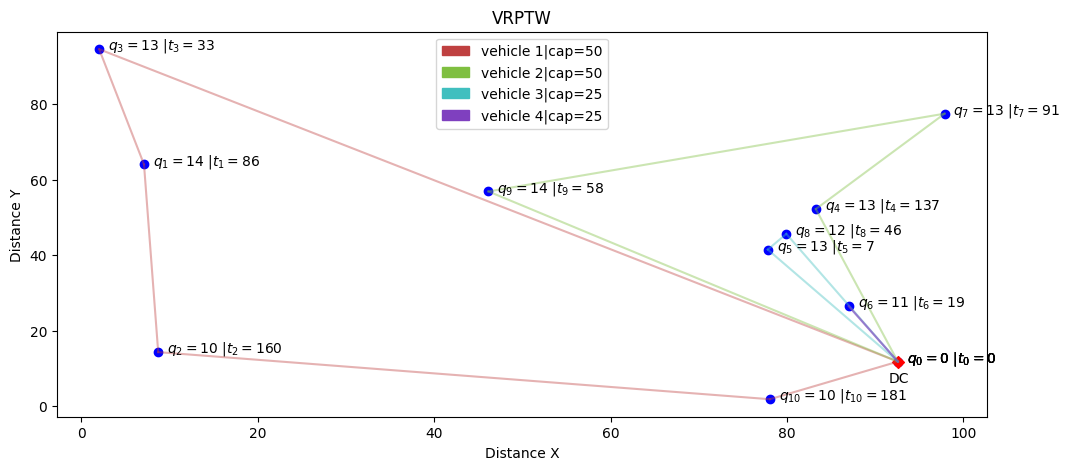

In [40]:
import matplotlib.patches as mpatches
from colour import Color

plt.figure(figsize=(12,5))
plt.scatter(X,Y,color='blue')

plt.scatter(X[0],Y[0],color = 'red', marker = 'D')
plt.annotate('DC',(X[0]-1,Y[0]-5.5))

for r in range(len(route)):
    route_color = Color(hue=r / len(route), saturation=0.5, luminance=0.5).hex
    for n in range(len(route[r])-1):
        i = route[r][n]
        j = route[r][n+1]
        plt.plot([X[i],X[j]],[Y[i],Y[j]], color = route_color, alpha=0.4)

for r in range(len(time_acum)):
    for n in range(len(time_acum[r])):
        i = route[r][n]
        plt.annotate('$q_{%d}=%d$ |$t_{%d}=%d$'%(i,q[i],i,time_acum[r][n]),(X[i]+1,Y[i]))

patch = [mpatches.Patch(color=Color(hue=n / len(truck), saturation=0.5, luminance=0.5).hex,label='vehicle '+str(truck[n])+"|cap="+str(Q[truck[n]]))for n in range(len(truck))]
plt.legend(handles=patch, loc='best')
plt.xlabel('Distance X')
plt.ylabel('Distance Y')
plt.title('VRPTW')

plt.show()